## Context

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

## Inspiration
Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
import sklearn
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams

rcParams['figure.figsize'] = 14,8
RANDOM_SEED = 42
LABELS = ['NORMAL','FRAUD']

In [2]:
df = pd.read_csv('/Users/shreyanshpandey/Downloads/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
#it will give us all the info about all the features in our dataset i.e. dtype id there any nnull value or not etc etc
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
#Create independent and Dependent Features
columns = df.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = df[columns]
Y = df[target]
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(284807, 30)
(284807,)


# Exploratory Data Analysis

In [5]:
#this will check wether our data has any missing values or not
df.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

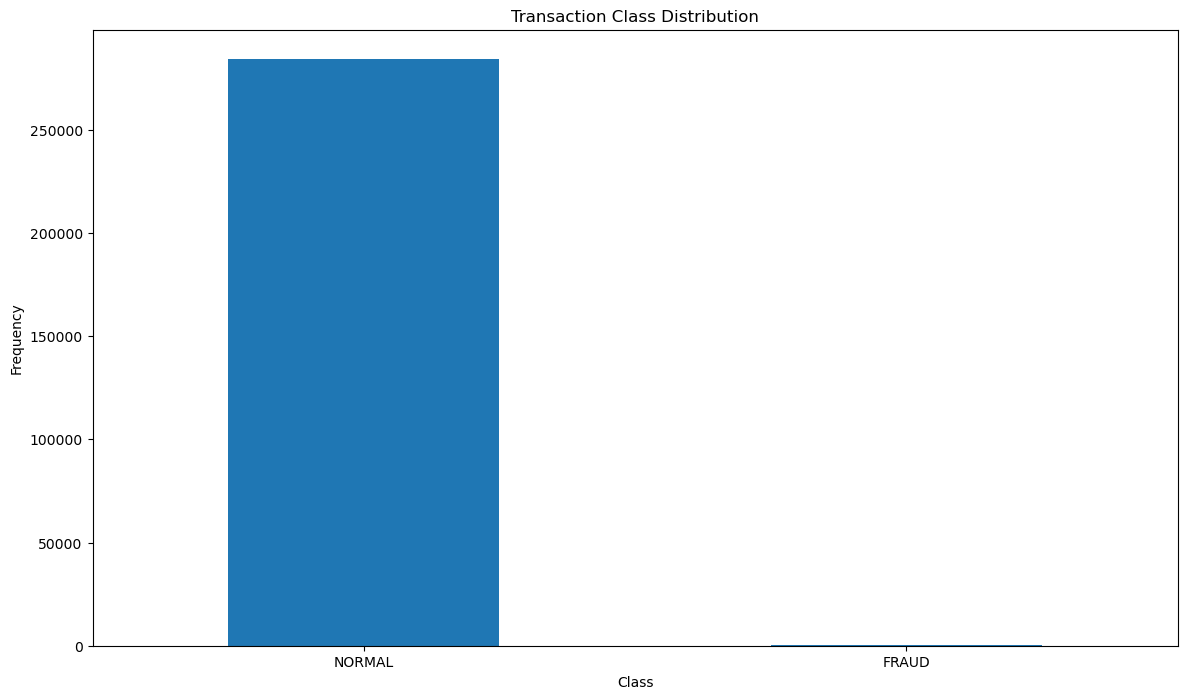

In [6]:
#here we can see no. of instances of labels and see if there is data imbalance or not
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [7]:
#get numbers
fraud = df[df['Class']==1]
valid = df[df['Class']==0]

In [8]:
print(fraud.shape,valid.shape)

(492, 31) (284315, 31)


from above cell we can clearly see that our data is highly imbalanced so if we want our model to work correctly then we need to create balance between both categories either by over-sampling or the under-sampling that is subjective to the dataset you are working on.

In [9]:
from sklearn.model_selection import train_test_split

#create test train split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.25,random_state=42)

In [10]:
#import the library for oversampling 
from imblearn.combine import SMOTETomek
smk = SMOTETomek(random_state=42)

In [11]:
#doing our oversampling for training and testing datasets seperately to avoid data leakage
X_train_res,y_train_res = smk.fit_resample(X_train,y_train)
X_test_res, y_test_res = smk.fit_resample(X_test,y_test)

In [12]:
# it will print no. of occourences of each output
from collections import Counter
print("Original Dataset shape {}".format(Counter(y_train)))
print("Resampled Dataset shape {}".format(Counter(y_train_res)))

Original Dataset shape Counter({0: 213226, 1: 379})
Resampled Dataset shape Counter({0: 212613, 1: 212613})


In [13]:
# importing decision tree 
from sklearn.tree import DecisionTreeClassifier
# it will select the best parameters for us to get best output
from sklearn.model_selection import GridSearchCV

In [14]:
# Decision tree Classifier
params = {'criterion':['gini','entropy','log_loss'],
         'splitter':['best','random'],
         'max_depth':[3,5,8,10,15,20],
         'max_features':['auto','sqrt','log2']}

decisionTree = DecisionTreeClassifier()
classifier = GridSearchCV(decisionTree,params,verbose=False)
classifier.fit(X_train_res,y_train_res)

/Users/shreyanshpandey/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/shreyanshpandey/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/shreyanshpandey/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/shreyanshpandey/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

/Users/shreyanshpandey/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/shreyanshpandey/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/shreyanshpandey/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/shreyanshpandey/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

/Users/shreyanshpandey/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/shreyanshpandey/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/shreyanshpandey/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/shreyanshpandey/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

/Users/shreyanshpandey/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/shreyanshpandey/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/shreyanshpandey/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/shreyanshpandey/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

/Users/shreyanshpandey/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/shreyanshpandey/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/shreyanshpandey/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/shreyanshpandey/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

/Users/shreyanshpandey/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/shreyanshpandey/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/shreyanshpandey/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/shreyanshpandey/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 5, 8, 10, 15, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'splitter': ['best', 'random']},
             verbose=False)

In [15]:
classifier.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'auto',
 'splitter': 'best'}

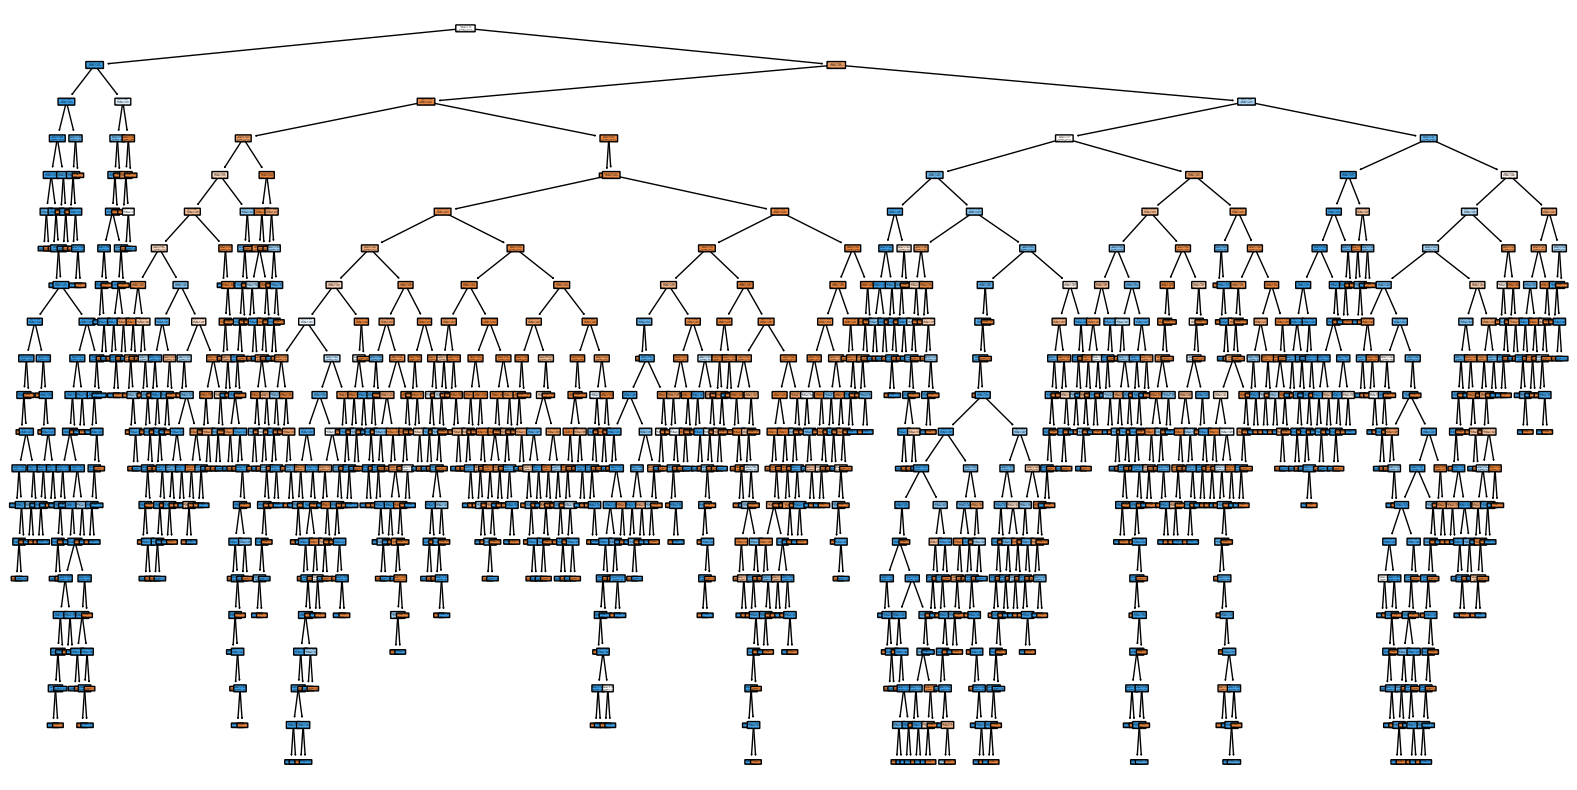

In [17]:
from sklearn.tree import plot_tree

best_dtree = classifier.best_estimator_

plt.figure(figsize=(20, 10))
plot_tree(best_dtree, filled=True,rounded=True)
plt.show()


In [18]:
#y-pred model prediction
y_pred = classifier.predict(X_test_res)

In [19]:
len(y_pred)

140858

In [20]:
from sklearn.metrics import accuracy_score,classification_report

print(classification_report(y_test_res,y_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     70429
           1       1.00      0.89      0.94     70429

    accuracy                           0.95    140858
   macro avg       0.95      0.95      0.95    140858
weighted avg       0.95      0.95      0.95    140858



In [21]:
print(accuracy_score(y_pred,y_test_res))

0.9454912039074813


In [22]:
def check_for_data_leak(train_data, test_data, features_to_exclude=None):
    """
    Check for potential data leaks between training and testing data.
    
    Parameters:
    - train_data: DataFrame, training dataset
    - test_data: DataFrame, testing dataset
    - features_to_exclude: list, features to exclude from the comparison (optional)

    Returns:
    - leak_detected: bool, True if potential data leak is detected, False otherwise
    """

    # Identify features for comparison
    if features_to_exclude is None:
        features_to_compare = train_data.columns
    else:
        features_to_compare = [col for col in train_data.columns if col not in features_to_exclude]

    # Check for common instances between training and testing data
    common_instances = pd.merge(train_data[features_to_compare], test_data[features_to_compare], how='inner')

    # If there are common instances, potential data leak is detected
    leak_detected = not common_instances.empty

    return leak_detected

# Example usage:
# Assuming you have pandas DataFrames 'train_data' and 'test_data'
leak_detected = check_for_data_leak(X_train_res, X_test_res)
print("Data leak detected:", leak_detected)

Data leak detected: True


As we can see clearly that data leakage is not eliminated in our model this is because we got data after applying PCA on original data and we cannot fetch the original data and we also don't actual column names of the features so cannot even get a proper understanding of features and their relation with the output and we can't determine if this data leakage is something related to temporal features or not so we can reduce the extent of data leakage in this dataset but we have reduced it and predictions are down from 100% accurate to 95% because of seperate pre-processing on training and testing data .